# Part 2: Data Preparation

Tasks: Data Loading, Data Cleaning, Identify Features Types, Features Engineering, Features Encoding, Target and Feature Creation, Train-test Split, Feature Scaling

## Data Loading

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

# Load the raw data
DATA_PATH = "../data/raw/modern_teen_mental_health_main.csv"
df = pd.read_csv(DATA_PATH)

# Data Cleaning

MISSING:          missing_count  missing_percentage
ai_tool          12009               40.03
-----------------------------------------------------------------------------
NO DUPLICATE ROWS FOUND IN THE DATASET
-----------------------------------------------------------------------------


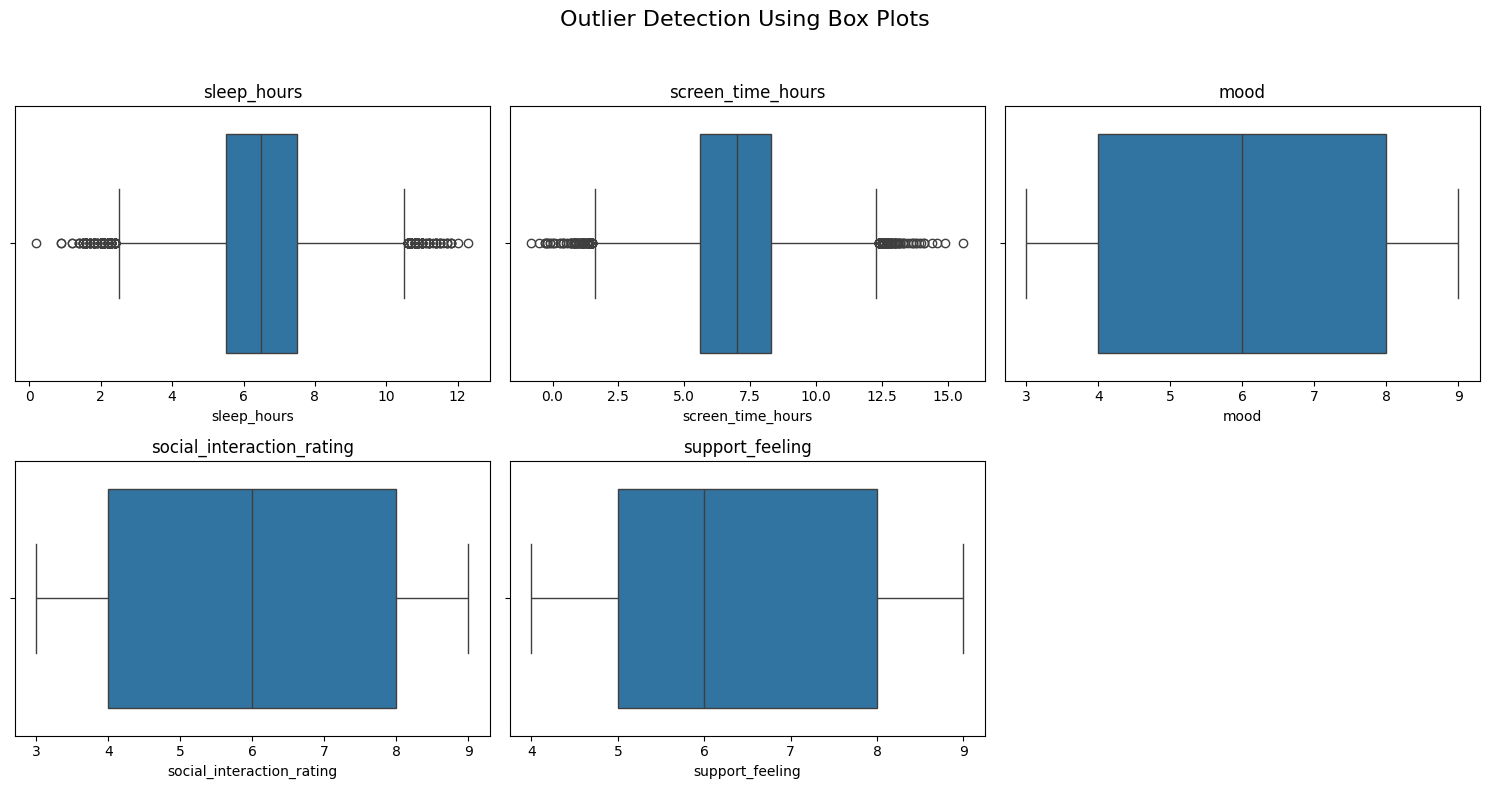

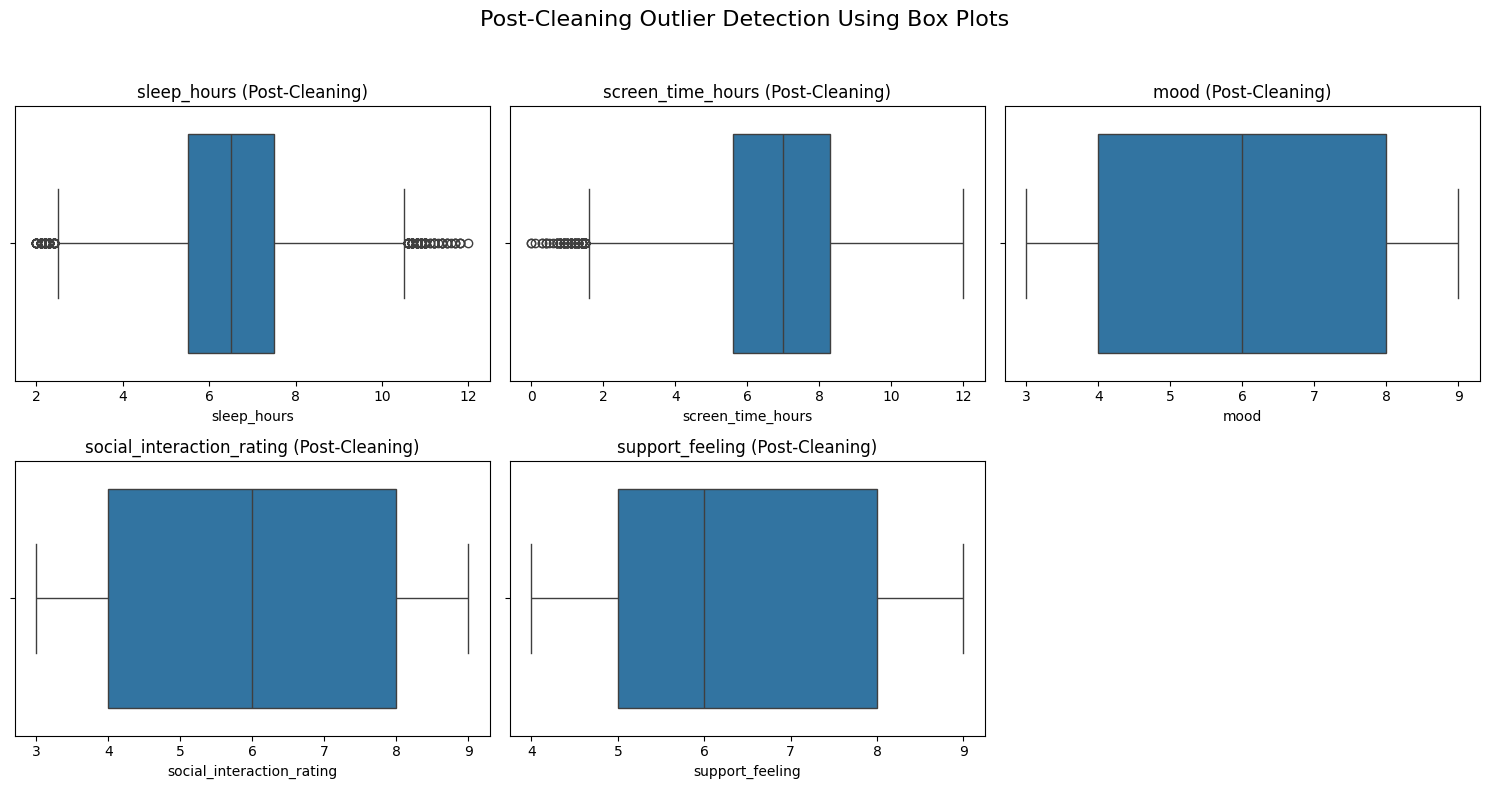

In [2]:
# ============================================
# 1. MISSING VALUES: absolute and percent
# ============================================
# Checking missing percent for every column
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (df.isnull().mean() * 100).sort_values(ascending=False)
missing_table = pd.concat([missing, missing_pct], axis=1, keys=['missing_count', 'missing_percentage']) 
missing_table = missing_table[missing_table['missing_count'] > 0].sort_values(by='missing_count', ascending=False)
if missing_table['missing_count'].sum() > 0:
    print("MISSING:", missing_table)
df.drop(columns='ai_tool', inplace=True) #Column 'ai_tool' has high missingness.Dropping 'ai_tool' from the dataset.
print("-----------------------------------------------------------------------------")
# ============================================
# 2. CHECK DUPLICATES IN DATASET 
# ============================================
duplicates_found = df.duplicated().any()
if not duplicates_found:
    print('NO DUPLICATE ROWS FOUND IN THE DATASET')
print("-----------------------------------------------------------------------------")
# ============================================================
# 3. OUTLIER DETECTION: Box plots for numerical features
# ============================================================
outlier_cols = [
    'sleep_hours',
    'screen_time_hours',
    'mood',
    'social_interaction_rating',
    'support_feeling'
]
cols = outlier_cols
n_cols = 3  
n_rows = math.ceil(len(cols)/n_cols)
plt.figure(figsize=(15, 4*n_rows))
for i, col in enumerate(cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.suptitle("Outlier Detection Using Box Plots", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../reports/figures/3_Outlier Detection/1.BeforeRemoval.png")
#plt.show()
# Handling outliers based on boxplot observations
# 1. Removing the impossible negative screen time values 
df = df[df['screen_time_hours'] >= 0]
# 2. Capping extreme screen time values (e.g., > 12 hours)
df.loc[df['screen_time_hours'] > 12, 'screen_time_hours'] = 12
# 3. Removing extreme sleep outliers (Removing > 12 hours)
df = df[df['sleep_hours'] <= 12]
# 4. Removing extreme sleep less than 2 hours(based on boxplot, 0.2 hrs could be data error. Hence, removing it)
df = df[df['sleep_hours'] >= 2]
plt.figure(figsize=(15, 4*n_rows))
for i, col in enumerate(cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[col])
    plt.title(f"{col} (Post-Cleaning)")
plt.suptitle("Post-Cleaning Outlier Detection Using Box Plots", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../reports/figures/3_Outlier Detection/2.AfterRemoval.png")
#plt.show()

# ============================================================
# ~ Key Insights about the Dataset ~
# - Column 'ai_tool' has high missingness, dropping it from the dataset because it is not essential for analysis. 
# Dataset already has 'used_ai_today' feature. 
# - No duplicates found and unique values per column are printed for better understanding of the data.
# - Negative screen time values were identified as data entry errors and removed.
# - Extreme outliers in sleep hours greater than 12 hours and less than 2
#   hours were removed to ensure data quality.
# - Capping screen time at 12 hours for extreme values (greater than 12).
#-------------------------------------------------------------  

## Identify Feature Types

In [3]:
# ============================================
# 5. PREVIEW DATA: Feature groups by data type
# ============================================
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numerical:", numerical_cols)
print("Categorical:", categorical_cols)


Numerical: ['age', 'mood', 'stress_level', 'sleep_hours', 'screen_time_hours', 'social_interaction_rating', 'support_feeling']
Categorical: ['student_id', 'date', 'gender', 'country', 'grade']


## Feature Engineering

In [4]:
# ===========================================================
# 6. DATE FEATURE ENGINEERING: Extracting day
# ===========================================================
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df = df.drop(columns=['month', 'year', 'date'])


# ============================================================
# ~ Key Insights about the Dataset ~
# - mood and stress_level have a -0.93 correlation. Mood is reverse of stress and
#the model will rely 100% on the mood score and ignore all other habits like sleep or exercise.
# - Model should use other features to find the hidden patterns in the actual data.
# - /notebooks/03_modelling_v1 - In this file, train-test data is trained WITH "mood" 
#and we can see accuracy and model results.
#- /notebooks/03_modelling_v2 - In this file, train-test data is trained WITHOUT "mood" feature. 
#------------------------------------------------------------- 

## Feature Encoding

In [5]:
# ============================================
# 7. Categorical Columns Encoding for gender, country, grade
# ============================================
df = pd.get_dummies(df, columns=['gender'], drop_first=True)  #One hot encoding
df = pd.get_dummies(df, columns=['country'], drop_first=True) 

# ============================================================
# 8. Ordinal Encoding for 'grade' column
# ============================================================
grade_map = {'9th': 9, '10th': 10, '11th': 11, '12th': 12}
df['grade'] = df['grade'].map(grade_map)

# ============================================================
# 9. BOOLEAN COLUMNS CONVERSION TO INTEGER
# ============================================================
bool_cols = df.select_dtypes('bool').columns
df[bool_cols] = df[bool_cols].astype(int)

## Target and Features Creation

In [6]:
# ============================================================
# 10. TARGET and FEATURES creation
# ============================================================
# 1. Create the categorical target
def categorize_stress(val):
    if val <= 2: return 0   # Low
    elif val <= 5: return 1 # Medium
    else: return 2          # High
df['target'] = df['stress_level'].apply(categorize_stress)
df.drop(columns='stress_level', inplace=True) #dropping target variable
#2. Features after target created
features = [col for col in df.columns if col != 'target'] #remaining features

#Define X and y properly
X = df[features]   
y = df['target']   


## Train-test split

In [ ]:
# ============================================================
# 11. TRAIN-TEST Split data
# ============================================================
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, #80% train, 20% test
    random_state=42,
    stratify=y
)
#Save the student IDs for later 
#test_student_ids = X_test_raw[['student_id']]
#Drop student_id AFTER saving it
X_train = X_train_raw.drop(columns=['student_id'], errors='ignore')
X_test = X_test_raw.drop(columns=['student_id'], errors='ignore')

# ============================================================
# ~ Key Insights about the Dataset ~
# - student_id is an unique identifier
# - If not dropped, model will just memorize the desired result for that student_id, rather 
#than learning why based on other features. This leads to overfitting.
#------------------------------------------------------------- 

## Feature Scaling

In [8]:
# ============================================================
# 12. FEATURE SCALING: Setup
# ============================================================
# Identify numerical columns with ranges larger than 1
cols_to_scale = [
    'age', 'grade', 'sleep_hours','mood',
    'screen_time_hours', 'social_interaction_rating',
    'support_feeling', 'day'
]

scaler = StandardScaler()

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
print("Split and Scaling complete. 'test_student_ids.csv' has been created.")

Split and Scaling complete. 'test_student_ids.csv' has been created.


In [ ]:
# ============================================================
# 12. SAVE THE FINAL DATASETS
# ============================================================
# Save in directory path
output_dir = "../data/processed_v2/"

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save all five files to the processed data folder
X_train.to_csv(os.path.join(output_dir, 'X_train_final.csv'), index=False)
X_test.to_csv(os.path.join(output_dir, 'X_test_final.csv'), index=False)
y_train.to_csv(os.path.join(output_dir, 'y_train_final.csv'), index=False)
y_test.to_csv(os.path.join(output_dir, 'y_test_final.csv'), index=False)
#test_student_ids.to_csv(os.path.join(output_dir, 'test_student_ids.csv'), index=False)

print(f"All files successfully saved to: {output_dir}")


All files successfully saved to: ../data/processed_v2/
